In [26]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [27]:
def wrangle(df_path):
    df=pd.read_csv(df_path)
    
    # drop columns with no predictive power
    drop_cols=['Ticket','Fare', 'Name']
    
    # drop column with many null values
    drop_cols.append('Cabin')

    # drop 	PassengerId 
    drop_cols.append('PassengerId')

    # drop columns
    df.drop(columns=drop_cols, inplace=True)
    return df 
    

In [28]:
df = wrangle('train.csv')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


<Axes: >

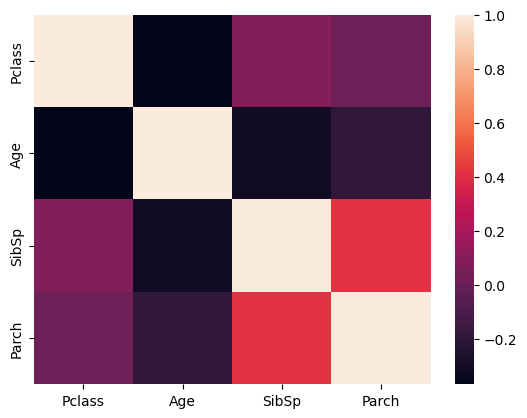

In [30]:
correlation = df.select_dtypes('number').drop(columns='Survived').corr()
# plot a heatmap
sns.heatmap(correlation)

Text(0.5, 1.0, 'Distribution of target by Age')

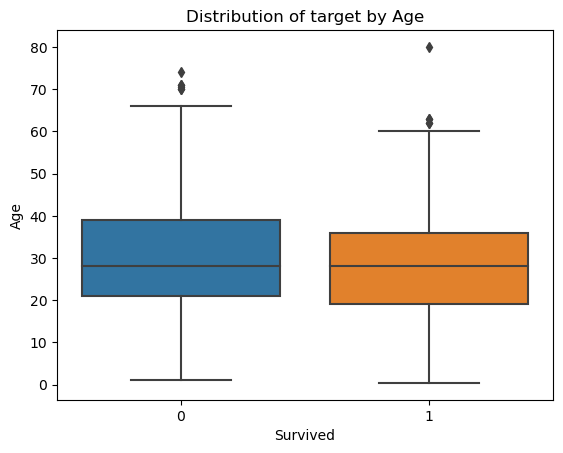

In [31]:
sns.boxplot(data=df, x='Survived', y='Age')
plt.title('Distribution of target by Age')


<Axes: xlabel='Survived'>

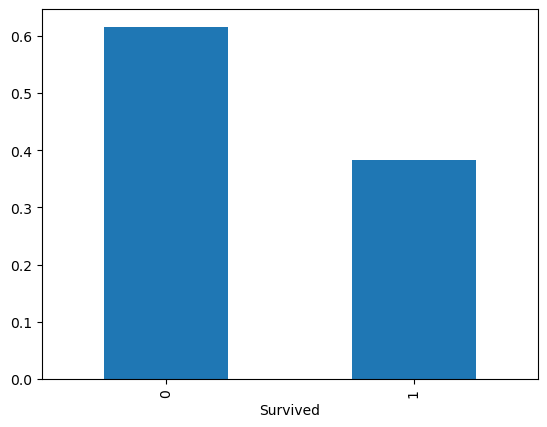

In [32]:
df['Survived'].value_counts(normalize=True).plot(kind='bar')

In [33]:
majority_class, minority_class = df['Survived'].value_counts(normalize=True)

In [34]:
# Pivot table for Pclass 
Pclass_pivot = pd.pivot_table(df, index='Pclass', values='Survived', aggfunc=np.mean).sort_values(by='Survived')
Pclass_pivot

,Survived
Pclass,
3,0.242363
2,0.472826
1,0.629630


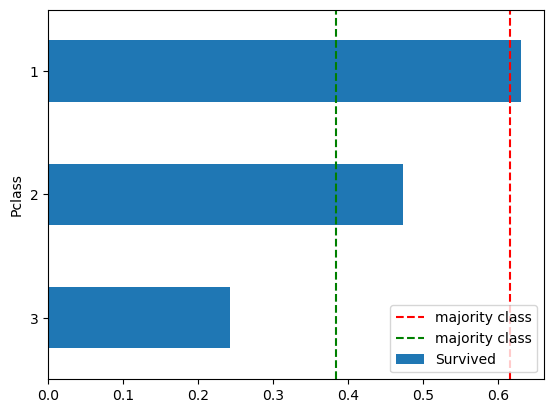

In [35]:
Pclass_pivot.plot(kind='barh')
plt.axvline(
    majority_class, linestyle='--', color='red', label= 'majority class'
)

plt.axvline(
    minority_class, linestyle='--', color='green', label= 'majority class'
)
plt.legend(loc='lower right')

Text(0, 0.5, 'freq')

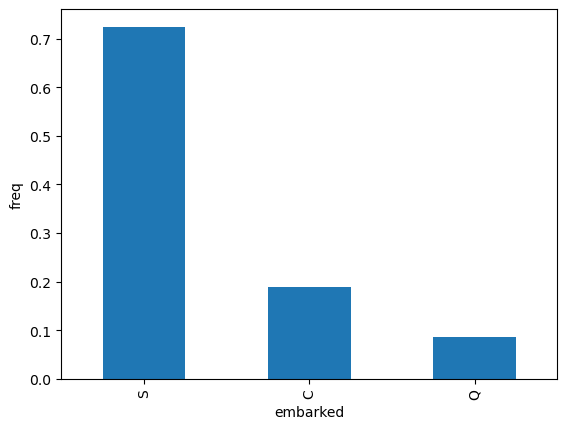

In [36]:
df['Embarked'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('embarked')
plt.ylabel('freq')

# Split

In [56]:
X=df.drop(columns='Survived')
y=df['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Model Building

In [57]:
# Decision trees
d_model= make_pipeline(OrdinalEncoder(), SimpleImputer(), DecisionTreeClassifier(random_state=42))
d_model.fit(X_train,y_train)
y_predictions = d_model.predict(X_train)
d_accuracy_train= accuracy_score(y_train, y_predictions)
d_accuracy_train

0.9367977528089888

In [55]:
d_accuracy = accuracy_score(y_test, d_model.predict(X_test))
d_accuracy

0.7653631284916201

# Hyperparameter tuning

In [49]:
max_depth = d_model.named_steps['decisiontreeclassifier'].get_depth()
max_depth

20

In [50]:
depth_hyperparams = range(1,22,2)
training_acc=[]
test_acc=[]

for d in depth_hyperparams:
    test_model = make_pipeline(OrdinalEncoder(), s_imputer, DecisionTreeClassifier(max_depth=d, random_state=42))
    # fit the data to the model
    test_model.fit(X_train,y_train)
    # Append the accuracy values to the lists 
    training_acc.append(test_model.score(X_train,y_train))
    test_acc.append(test_model.score(X_test, y_test))

print(f'Training acc:{training_acc[:3]}')
print(f'Test acc: {test_acc[:3]}')

Training acc:[0.7879213483146067, 0.8356741573033708, 0.8497191011235955]
Test acc: [0.7821229050279329, 0.7988826815642458, 0.7932960893854749]


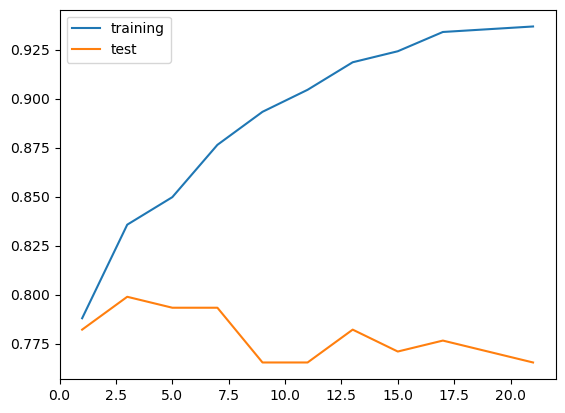

In [51]:
plt.plot(depth_hyperparams, training_acc, label='training')
plt.plot(depth_hyperparams, test_acc, label='test')
plt.legend()

# Score after hyperparameter tuning

In [58]:
d_model= make_pipeline(OrdinalEncoder(), SimpleImputer(), DecisionTreeClassifier(max_depth=3,random_state=42))
d_model.fit(X_train,y_train)
y_predictions = d_model.predict(X_train)
d_accuracy_train= accuracy_score(y_train, y_predictions)
d_accuracy_train

0.8356741573033708

In [60]:
test_accuracy =d_model.score(X_test,y_test)
test_accuracy

0.7988826815642458

# Communicate Results

In [61]:
features= X_train.columns
importances = d_model.named_steps['decisiontreeclassifier'].feature_importances_

In [63]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

Parch       0.000000
Embarked    0.039775
SibSp       0.049235
Age         0.077076
Pclass      0.214327
dtype: float64

Text(0, 0.5, 'features')

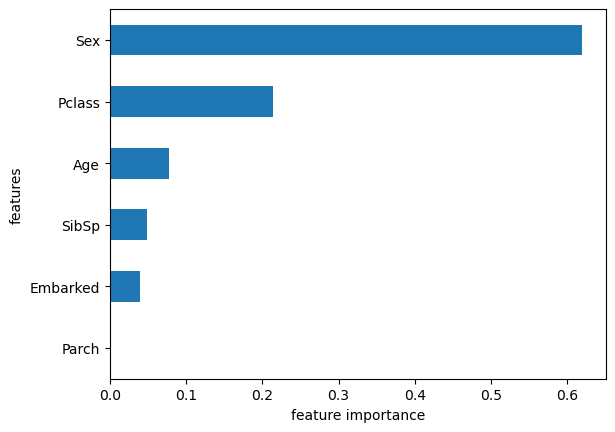

In [65]:
feat_imp.plot(kind='barh')
plt.xlabel('feature importance')
plt.ylabel('features')
